# Neighborhood Analysis

To find structures within our tissues, we can use the concept of cellular neighborhoods. The idea is that we start by defining neighborhoods for each cell, which consist of the relative abundances of the surrounding cell types. Afterwards, we can use clustering across multiple samples to define the neighborhoods. Finally, we can add these neighborhood labels back into the `spatialproteomics` object and use them to select specific regions of the tissue. Methods relating to neighborhoods are contained in the `nh` module. For convenience, you can use the `sp.ImageContainer` to perform this analysis with a single function call.

In [7]:
%reload_ext autoreload
%autoreload 2

import spatialproteomics as sp
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

## Neighborhood Analysis with the ImageContainer

As a first step, we open three datasets and store them inside of a dictionary.

In [13]:
sp_obj_1 = xr.open_dataset('../../data/sample_1.zarr', engine='zarr')
sp_obj_2 = xr.open_dataset('../../data/sample_2.zarr', engine='zarr')
sp_obj_3 = xr.open_dataset('../../data/sample_3.zarr', engine='zarr')

In [14]:
sp_dict = {'1': sp_obj_1, '2': sp_obj_2, '3': sp_obj_3}

Next, we put this dictionary into an `ImageContainer` and run the method `compute_neighborhoods()`. This will compute the neighborhoods for each object, and also run k-means clustering over all samples. If you want to do this yourself, please refer to the section at the end of this notebook.

In [15]:
image_container = sp.ImageContainer(sp_dict)
# this method returns a dict in the same format as we provided as input
sp_dict = image_container.compute_neighborhoods()

Neighborhood Neighborhood 2 not found in the data object. Skipping.
Neighborhood Neighborhood 2 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.


Let's plot the cell type labels and the resulting neighborhoods.

Neighborhood Neighborhood 2 not found in the data object. Skipping.
Neighborhood Neighborhood 2 not found in the data object. Skipping.
Neighborhood Neighborhood 0 not found in the data object. Skipping.


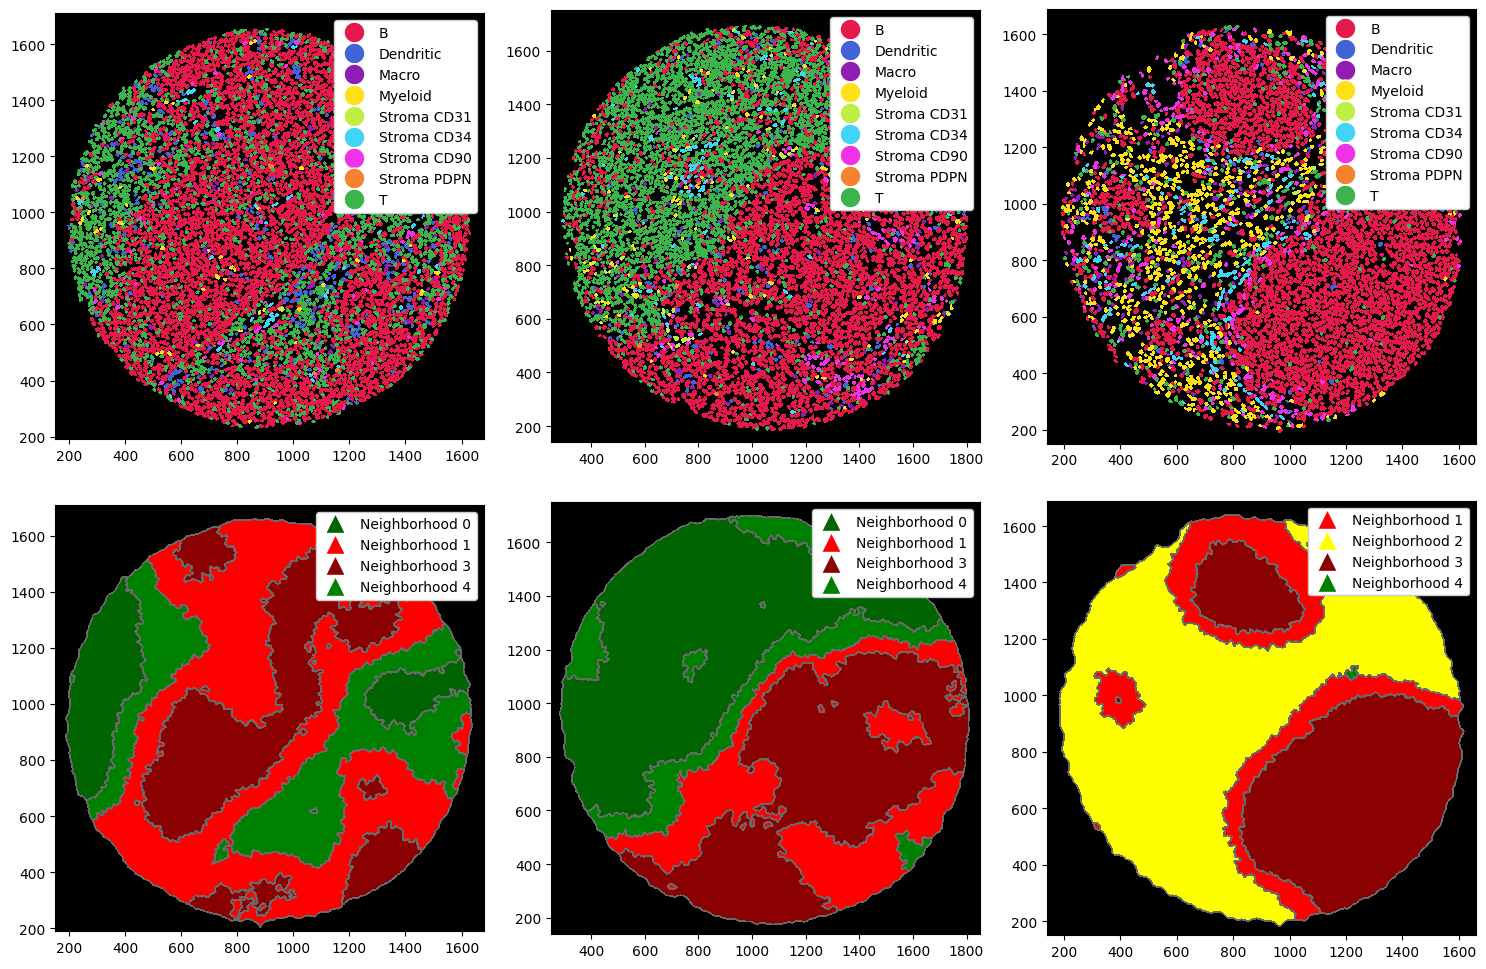

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()

# setting custom colors to be more in line with the cell types
neighborhoods, colors = [f'Neighborhood {x}' for x in np.arange(5)], ['darkgreen', 'red', 'yellow', 'darkred', 'green']

# plotting labels
_ = sp_dict['1'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[0])
_ = sp_dict['2'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[1])
_ = sp_dict['3'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[2])

# plotting neighborhoods
_ = sp_dict['1'].pl.autocrop().nh.set_neighborhood_colors(neighborhoods, colors).pl.show(render_image=False, render_neighborhoods=True, ax=ax[3])
_ = sp_dict['2'].pl.autocrop().nh.set_neighborhood_colors(neighborhoods, colors).pl.show(render_image=False, render_neighborhoods=True, ax=ax[4])
_ = sp_dict['3'].pl.autocrop().nh.set_neighborhood_colors(neighborhoods, colors).pl.show(render_image=False, render_neighborhoods=True, ax=ax[5])

plt.tight_layout()

# Custom Neighborhood Analysis

In case the `ImageContainer` does not contain all of the functionality you desire, you can also customize the workflow. This is a bit more cumbersome, but the code below illustrates a possible approach.

We can use the method `nh.compute_neighborhoods_radius()` to compute the neighborhood profiles, which will be written into a new layer called `_neighborhoods`. This method takes a radius around each cell and returns the relative cell type frequencies within that radius. Here, we use `pp.get_layer_as_df()` to investigate what this looks like.

In [23]:
# resetting the dictionary
sp_dict = {'1': sp_obj_1, '2': sp_obj_2, '3': sp_obj_3}

# computing the neighborhood matrix
sp_obj_1_with_neighborhood = sp_obj_1.nh.compute_neighborhoods_radius()
sp_obj_1_with_neighborhood

<xarray.Dataset>
Dimensions:                (cells: 6901, celltype_levels: 3, channels: 56,
                            y: 2000, x: 2000, labels: 9, la_props: 2,
                            features: 17)
Coordinates:
  * cells                  (cells) int64 1 2 3 4 5 ... 6897 6898 6899 6900 6901
  * celltype_levels        (celltype_levels) <U8 'labels' 'labels_1' 'labels_2'
  * channels               (channels) <U11 'DAPI' 'TIM3' ... 'ki-67' 'CD38'
  * features               (features) <U10 'BCL-2' 'BCL-6' ... 'ki-67'
  * la_props               (la_props) <U6 '_color' '_name'
  * labels                 (labels) int64 1 2 3 4 5 6 7 8 9
  * x                      (x) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
  * y                      (y) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
Data variables:
    _celltype_predictions  (cells, celltype_levels) <U11 ...
    _image                 (channels, y, x) uint8 ...
    _la_properties         (labels, la_props) <U11 ...
    _obs                   (cells, features) float64 1.0 1.0 0.0 ... 904.5 0.0
    _segmentation          (y, x) int64 ...
    _neighborhoods         (cells, labels) float64 0.7812 0.0 0.0 ... 0.0 0.2344

In [5]:
# checking what the neighborhoods layer looks like
sp_obj_1_with_neighborhood.pp.get_layer_as_df('_neighborhoods').head()

B  Dendritic  Macro   Myeloid  Stroma CD31  Stroma CD34  \
1  0.781250        0.0    0.0  0.015625          0.0          0.0   
2  0.779412        0.0    0.0  0.014706          0.0          0.0   
3  0.761194        0.0    0.0  0.029851          0.0          0.0   
4  0.753846        0.0    0.0  0.030769          0.0          0.0   
5  0.811594        0.0    0.0  0.014493          0.0          0.0   

   Stroma CD90  Stroma PDPN         T  
1     0.000000          0.0  0.203125  
2     0.000000          0.0  0.205882  
3     0.014925          0.0  0.194030  
4     0.015385          0.0  0.200000  
5     0.000000          0.0  0.173913

Each cell now has a neighborhood associated with it, which is defined as the relative abundance of the surrounding cell types. This includes the cell itself, but you can change this behavior with the argument `include_center` when computing the neighborhoods). We can now do this across all three datasets, and then aggregate the results into a single data frame.

In [6]:
df = []
for id, sp_obj in sp_dict.items():
    df.append(sp_obj.nh.compute_neighborhoods_radius().pp.get_layer_as_df('_neighborhoods'))
# replacing nans with 0s (this means that the ct was never called in that specific sample)
df = pd.concat(df).fillna(0)
df.head()

B  Dendritic  Macro   Myeloid  Stroma CD31  Stroma CD34  \
1  0.781250        0.0    0.0  0.015625          0.0          0.0   
2  0.779412        0.0    0.0  0.014706          0.0          0.0   
3  0.761194        0.0    0.0  0.029851          0.0          0.0   
4  0.753846        0.0    0.0  0.030769          0.0          0.0   
5  0.811594        0.0    0.0  0.014493          0.0          0.0   

   Stroma CD90  Stroma PDPN         T  
1     0.000000          0.0  0.203125  
2     0.000000          0.0  0.205882  
3     0.014925          0.0  0.194030  
4     0.015385          0.0  0.200000  
5     0.000000          0.0  0.173913

We can now perform k-means clustering on this large data frame. Note that you could also use alternative clustering approaches, however some of them (e. g. hierarchical clustering) might be difficult to apply to large data sets, since they require the computation of a full pairwise distance matrix.

In [7]:
# Running K-Means clustering (here with k=3, you could adjust that to your liking)
clusterer = KMeans(n_clusters=3, random_state=0)
clusterer.fit(df)
kmeans_df = pd.DataFrame({f'neighborhood': clusterer.labels_})
kmeans_df.head()

neighborhood
0             1
1             1
2             1
3             1
4             1

Now we have a large data frame containing the neighborhood labels. We can add them back into the `spatialproteomics` objects with `nh.add_neighborhoods_from_dataframe()`.

In [8]:
for sample_id, sp_obj in sp_dict.items():
    # obtaining the number of cells contained in the object we are currently looking at
    num_cells = sp_obj.sizes['cells']
    # getting the labels for the number of cells
    tmp_df = kmeans_df[:num_cells]
    # removing those cells from the kmeans_df
    kmeans_df = kmeans_df[num_cells:]
    # storing the neighborhoods in the spatialproteomics objects
    # we can also set custom neighborhood colors here using .nh.set_neighborhood_colors()
    sp_dict[sample_id] = sp_obj.nh.add_neighborhoods_from_dataframe(tmp_df).nh.set_neighborhood_colors(np.arange(3), ['lightgreen', 'red', 'yellow'])

Neighborhood 2 not found in the data object. Skipping.
Neighborhood 0 not found in the data object. Skipping.


Finally, we can plot the results. Let's look at both the cellular neighborhoods as well as the original cell type labels.

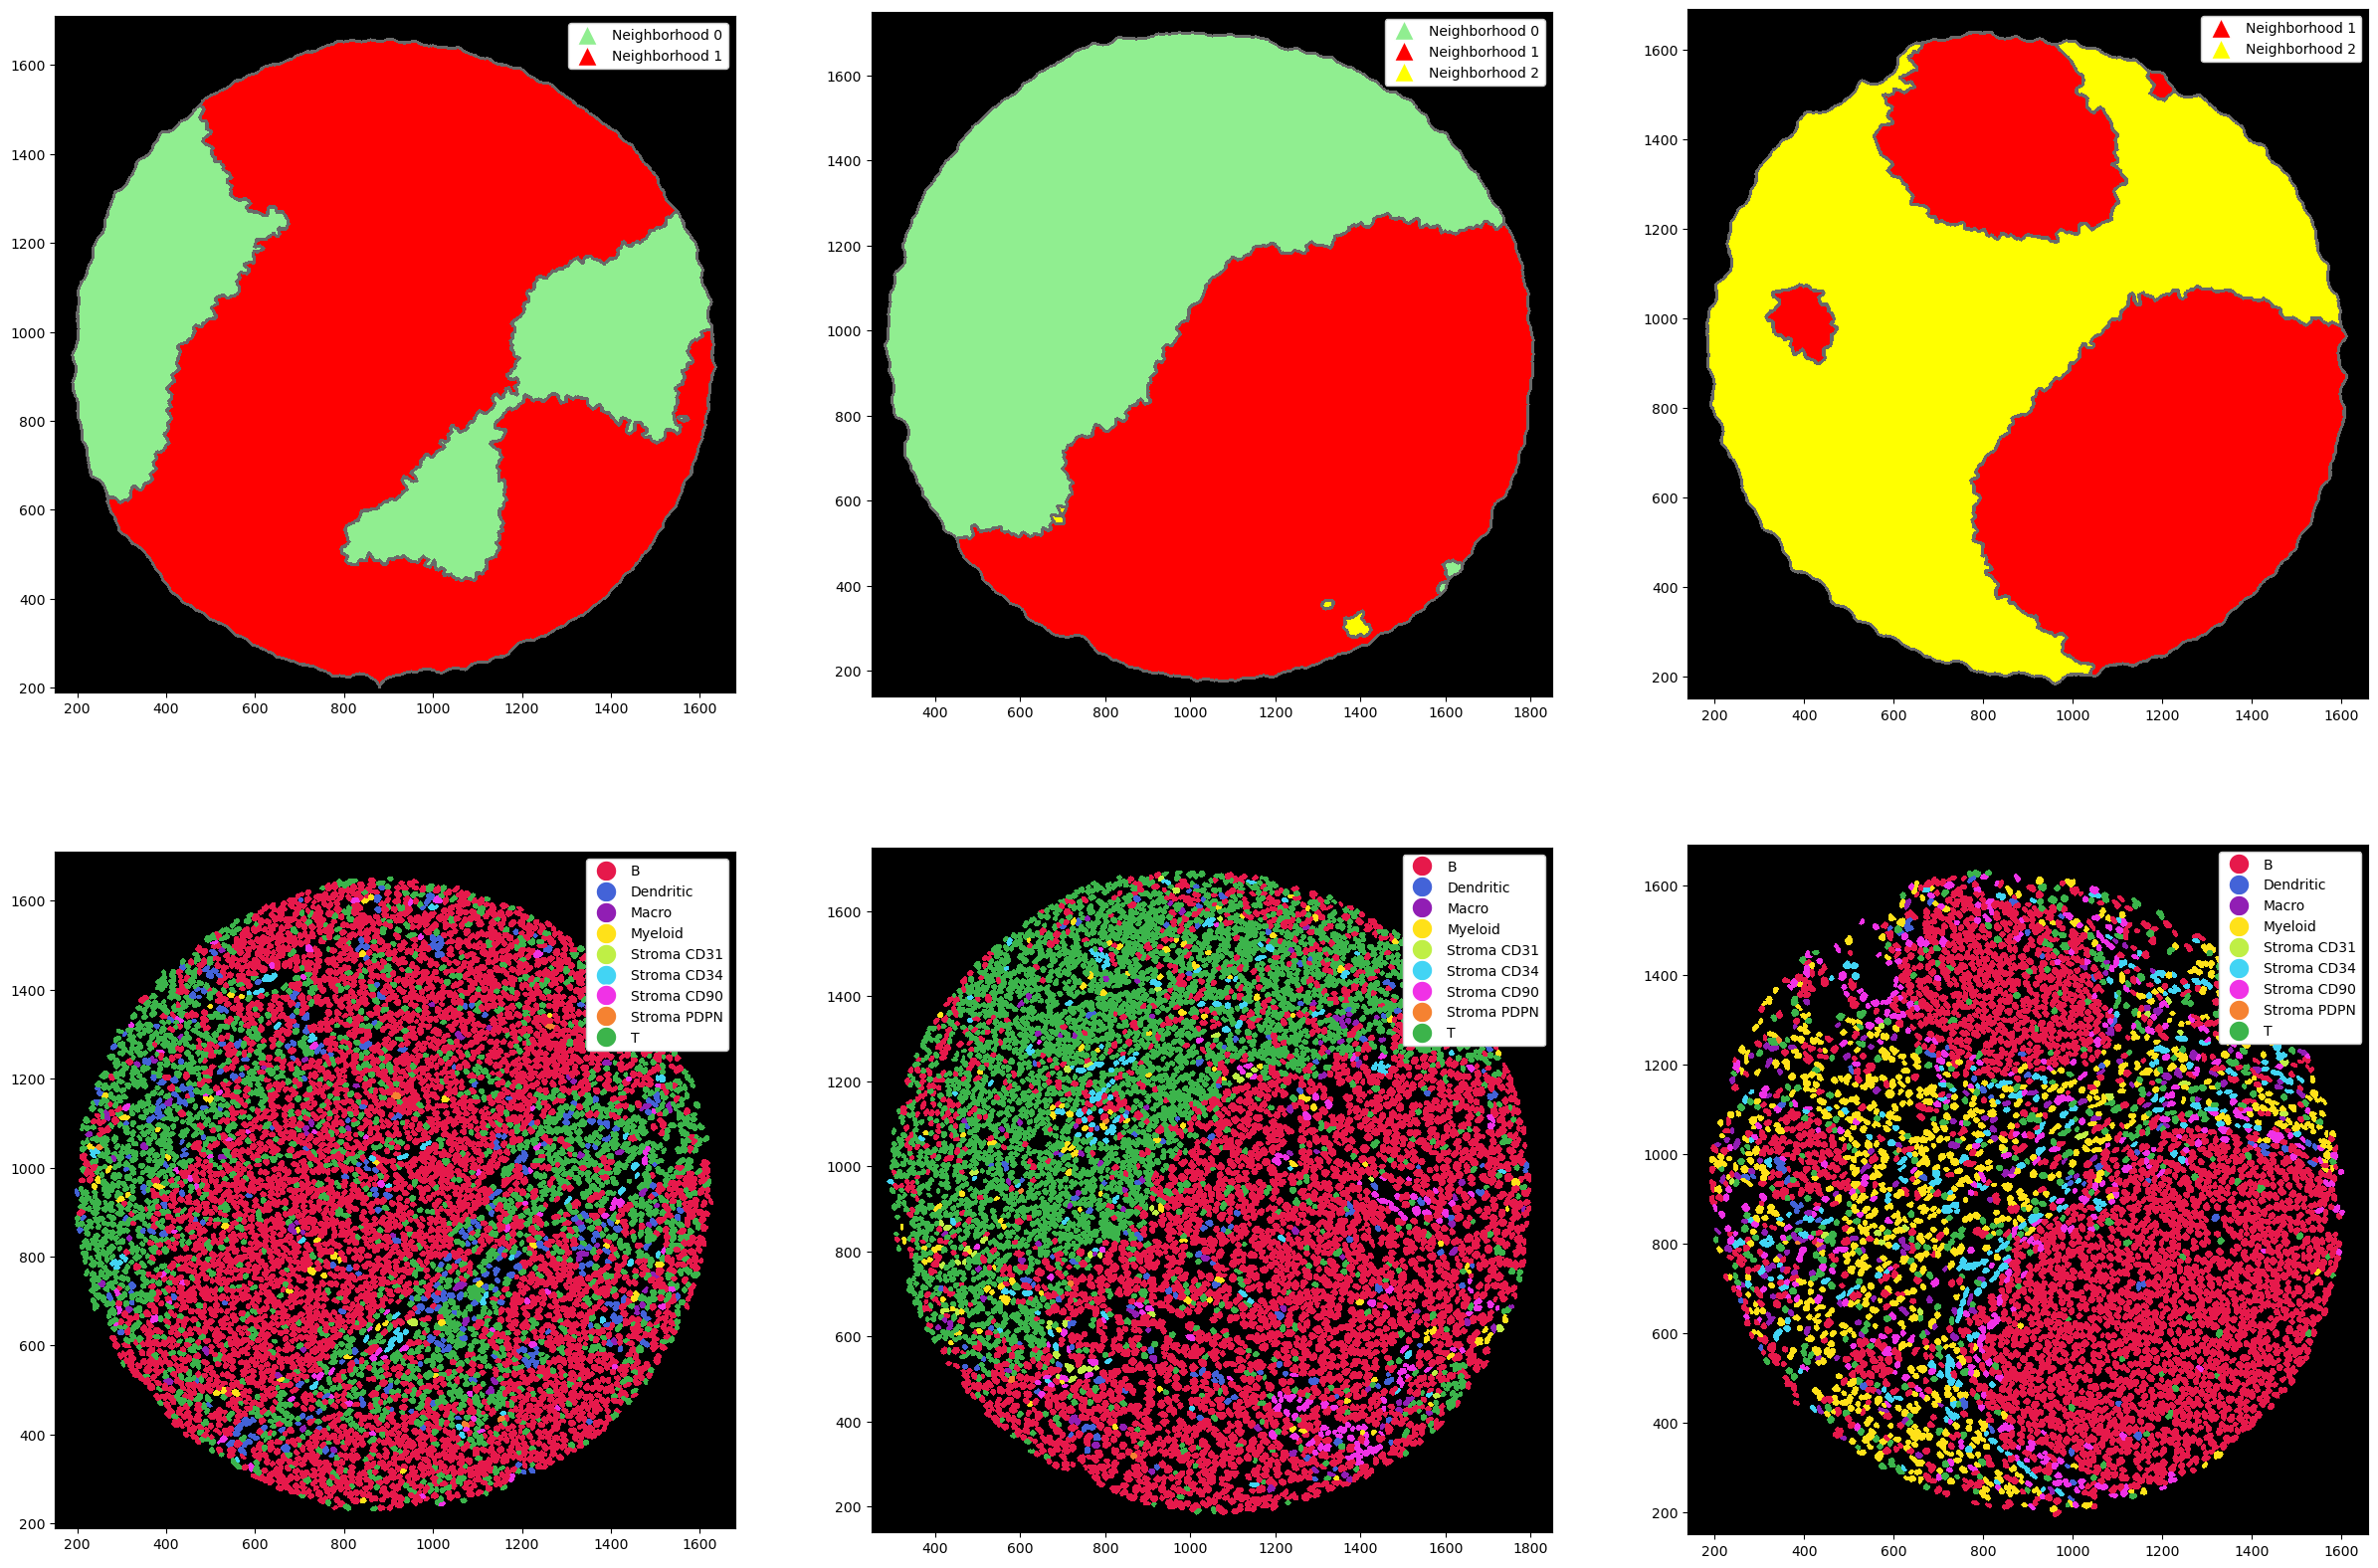

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
ax = ax.flatten()

_ = sp_dict['1'].pl.autocrop().pl.show(render_image=False, render_neighborhoods=True, ax=ax[0])
_ = sp_dict['2'].pl.autocrop().pl.show(render_image=False, render_neighborhoods=True, ax=ax[1])
_ = sp_dict['3'].pl.autocrop().pl.show(render_image=False, render_neighborhoods=True, ax=ax[2])

_ = sp_dict['1'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[3])
_ = sp_dict['2'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[4])
_ = sp_dict['3'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[5])

As you can see, our neighborhoods capture a B cell rich zone, a T cell rich zone, and a Myeloid rich zone. Depending on the amount of clusters you set, you can of course get different results, including more or less neighborhoods.

Once you have defined clusters, you may also rename the neighborhoods. In addition, note that you can also plot them on the cells directly, instead of using the region-based approach demonstrated above.

In [10]:
# renaming the neighborhoods
sp_dict['1'] = sp_dict['1'].nh.set_neighborhood_name('Neighborhood 0', 'T cell neighborhood')
sp_dict['1'] = sp_dict['1'].nh.set_neighborhood_name('Neighborhood 1', 'B cell neighborhood')

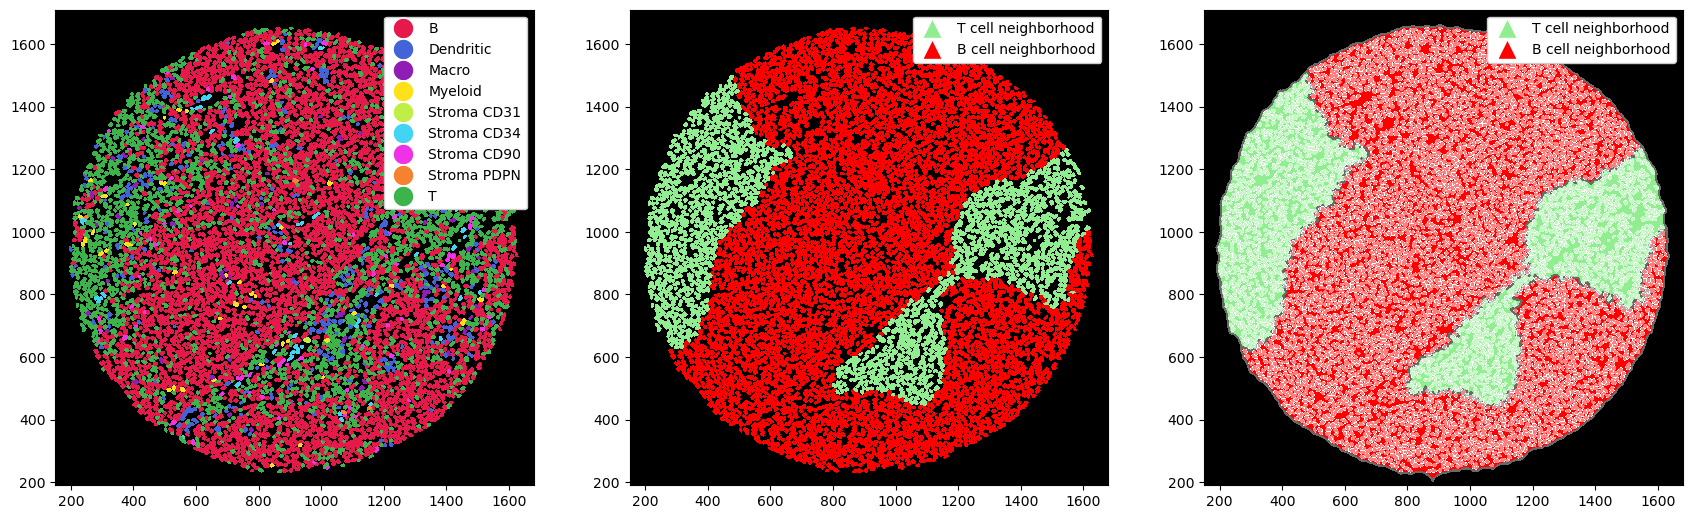

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax = ax.flatten()

_ = sp_dict['1'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[0])
# using the imshow syntax to have more control over the plot
# refer to the plotting notebook for more information
_ = sp_dict['1'].pl.autocrop().pl.render_neighborhoods(style='cells').pl.imshow(legend_neighborhoods=True, ax=ax[1])
# plotting the segmentation on top of the neighborhoods
_ = sp_dict['1'].pl.autocrop().pl.render_neighborhoods().pl.render_segmentation(alpha=0.5).pl.imshow(legend_neighborhoods=True, ax=ax[2])

# Comparison of different neighborhood methods
There are three main ways how a neighborhood can be computed: via a radius, a k-nearest neighborh graph, or a Delaunay triangulation.
In the `radius` method, a circle with a certain radius is drawn around a cell, and the cell type frequencies are aggregated.
With `knn`, the k nearest neighbors of a cell are counted as the neighborhood.
Finally, `delaunay` creates a Delaunay triangulation from the cell centroids and counts cells as part of each other's neighborhood if they are connected in the resulting graph.

Let's look at how these three methods perform on the example data from above.
To illustrate the differences better, we also cluster with a higher k, resulting in more neighborhoods. 
Note that you could do all of this with the `ImageContainer` as well.

In [20]:
# putting the strategy from above into a single method
def compute_and_plot_clusters(sp_dict, k=5, method='radius'):
    # ===== CREATION OF THE JOINT NEIGHBORHOOD DF =====
    df = []
    for id, sp_obj in sp_dict.items():
        if method == 'radius':
            df.append(sp_obj.nh.compute_neighborhoods_radius().pp.get_layer_as_df('_neighborhoods'))
        elif method == 'knn':
            df.append(sp_obj.nh.compute_neighborhoods_knn().pp.get_layer_as_df('_neighborhoods'))
        elif method == 'delaunay':
            df.append(sp_obj.nh.compute_neighborhoods_delaunay().pp.get_layer_as_df('_neighborhoods'))
    # replacing nans with 0s (this means that the ct was never called in that specific sample)
    df = pd.concat(df).fillna(0)
    
    # ===== K-MEANS CLUSTERING =====
    clusterer = KMeans(n_clusters=k, random_state=0)
    clusterer.fit(df)
    kmeans_df = pd.DataFrame({f'neighborhood': clusterer.labels_})

    # ===== ADDING NEIGHBORHOODS INTO SP OBJECTS =====
    for sample_id, sp_obj in sp_dict.items():
        # obtaining the number of cells contained in the object we are currently looking at
        num_cells = sp_obj.sizes['cells']
        # getting the labels for the number of cells
        tmp_df = kmeans_df[:num_cells]
        # removing those cells from the kmeans_df
        kmeans_df = kmeans_df[num_cells:]
        # storing the neighborhoods in the spatialproteomics objects
        # we can also set custom neighborhood colors here using .nh.set_neighborhood_colors()
        sp_dict[sample_id] = sp_obj.nh.add_neighborhoods_from_dataframe(tmp_df).nh.set_neighborhood_colors(np.arange(k), ['deepskyblue', 'orange', 'red', 'purple', 'blue'])
        
    # ===== PLOTTING =====
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax = ax.flatten()

    _ = sp_dict['1'].pl.autocrop().pl.show(render_image=False, render_neighborhoods=True, ax=ax[0])
    _ = sp_dict['2'].pl.autocrop().pl.show(render_image=False, render_neighborhoods=True, ax=ax[1])
    _ = sp_dict['3'].pl.autocrop().pl.show(render_image=False, render_neighborhoods=True, ax=ax[2])

    _ = sp_dict['1'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[3])
    _ = sp_dict['2'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[4])
    _ = sp_dict['3'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[5])
    
    for axis in ax:
        axis.set_xticks([])
        axis.set_yticks([])
    plt.suptitle(method)
    plt.tight_layout()
    plt.show()

Note that the colors for the neighborhoods were chosen arbitrarily here.

Neighborhoods are non-consecutive. Relabeling...
Neighborhood 2 not found in the data object. Skipping.
Neighborhoods are non-consecutive. Relabeling...
Neighborhood 2 not found in the data object. Skipping.
Neighborhood 0 not found in the data object. Skipping.


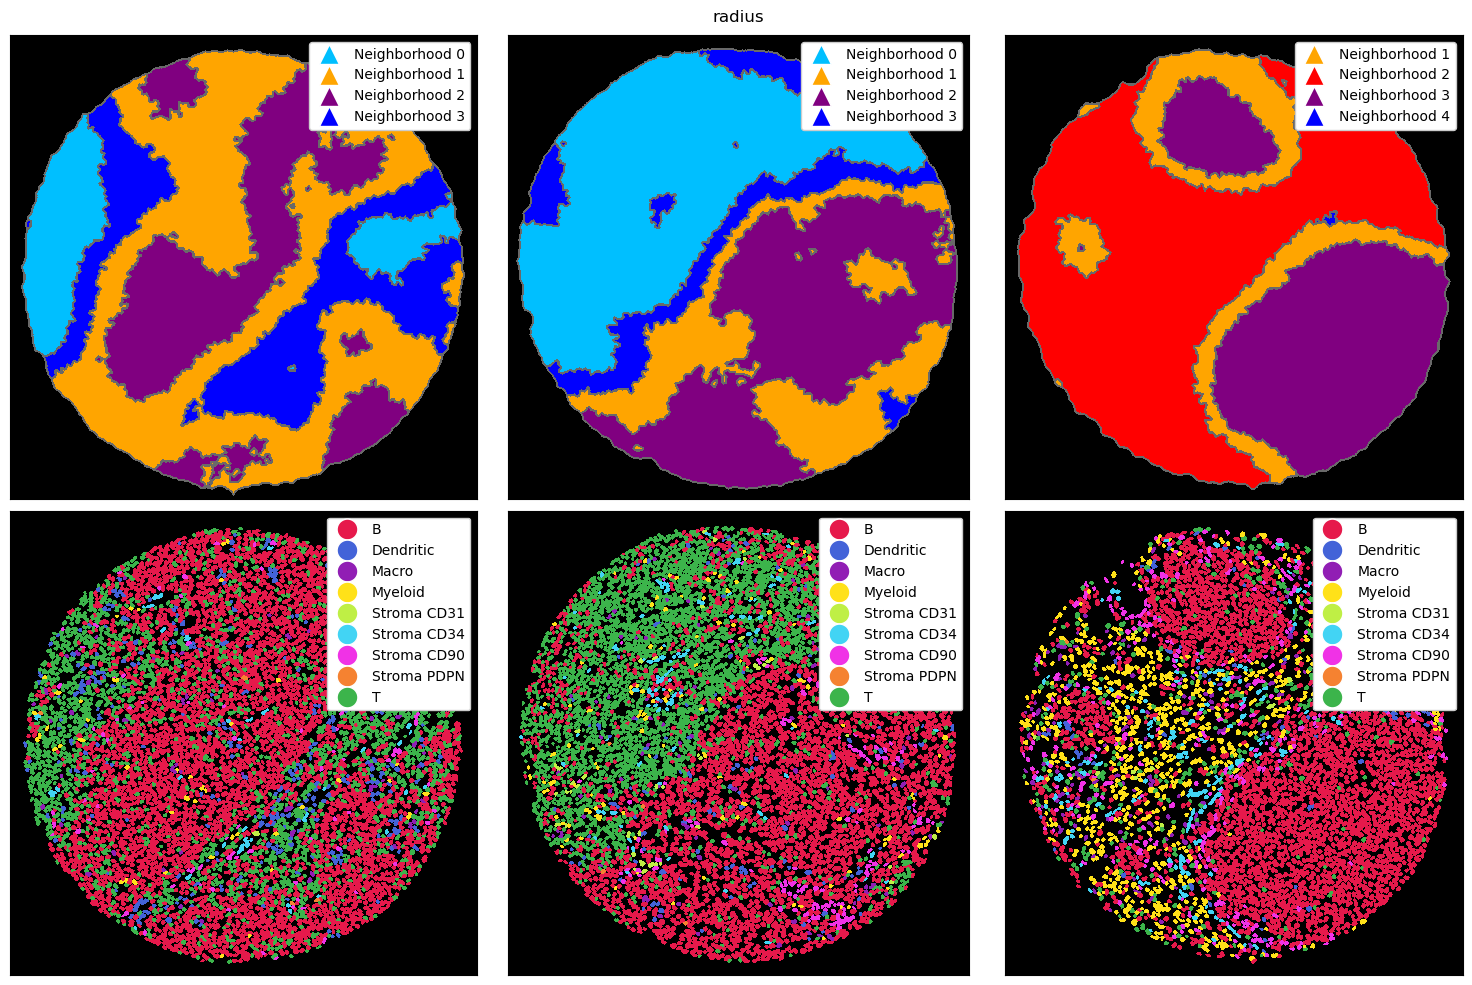

In [21]:
tmp_dict = {'1': sp_obj_1, '2': sp_obj_2, '3': sp_obj_3}
compute_and_plot_clusters(tmp_dict, k=5, method='radius')

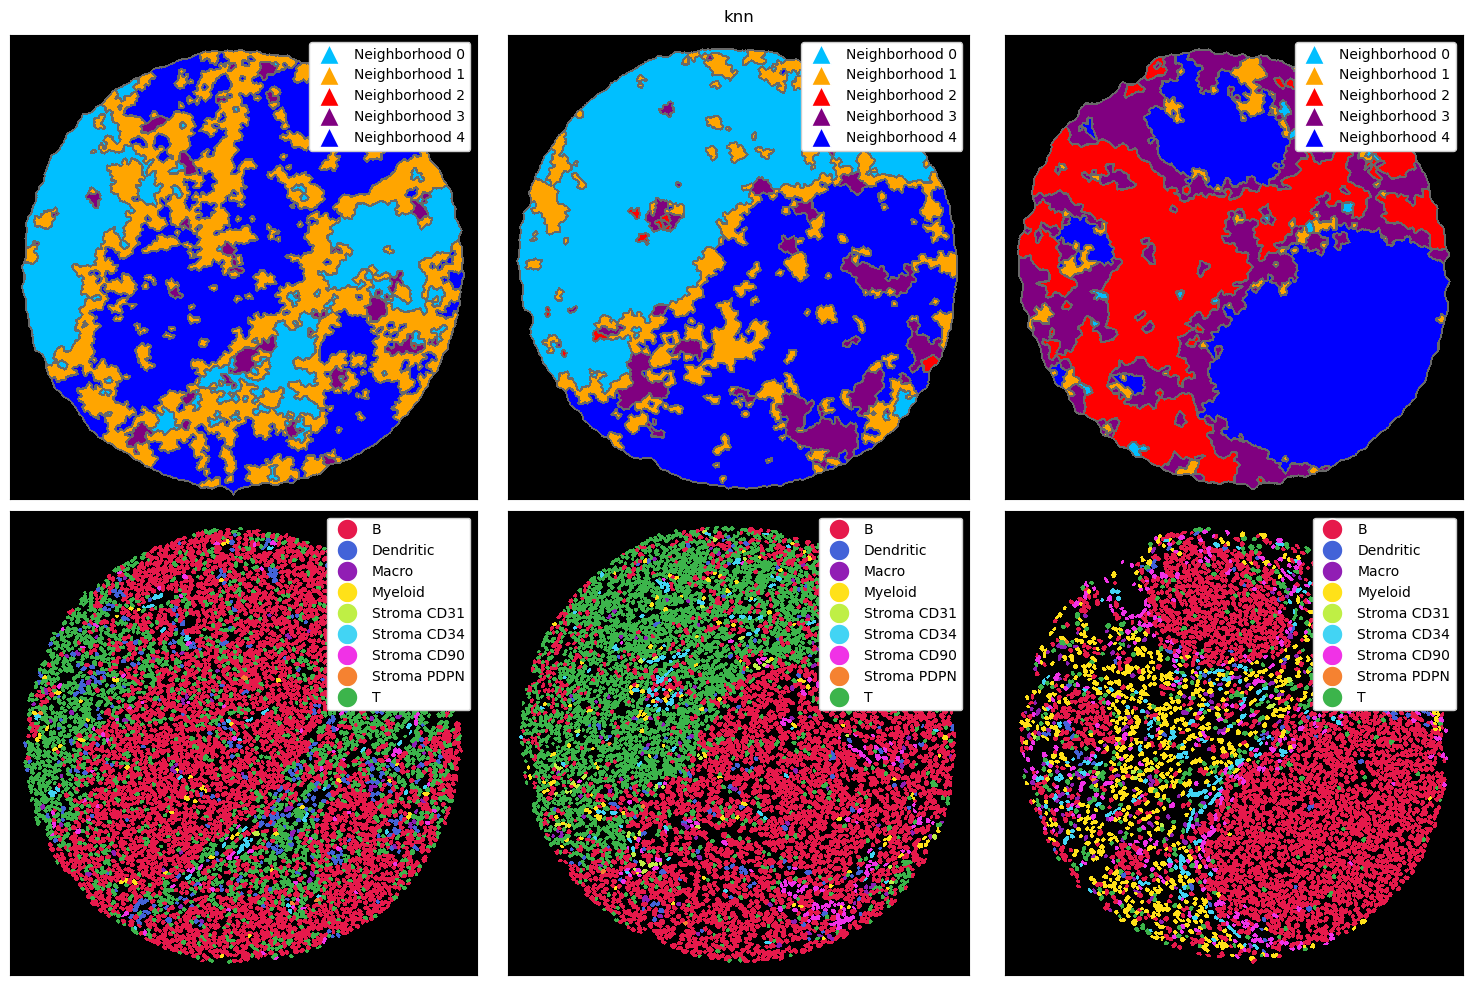

In [22]:
tmp_dict = {'1': sp_obj_1, '2': sp_obj_2, '3': sp_obj_3}
compute_and_plot_clusters(tmp_dict, k=5, method='knn')

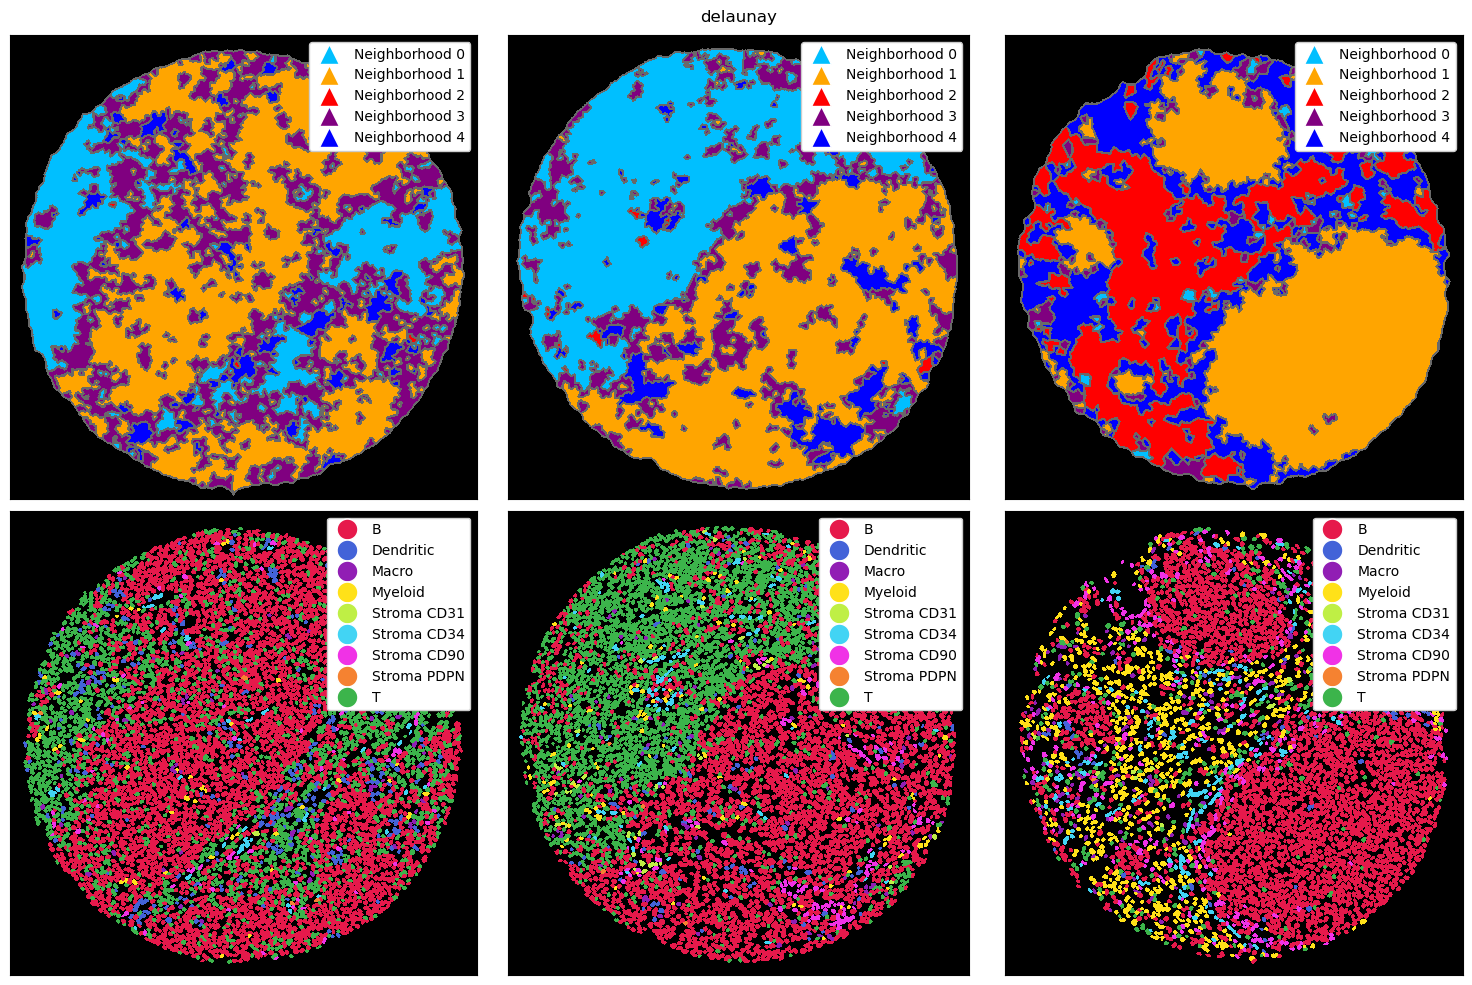

In [23]:
tmp_dict = {'1': sp_obj_1, '2': sp_obj_2, '3': sp_obj_3}
compute_and_plot_clusters(tmp_dict, k=5, method='delaunay')